# Lab 5: ML Life Cycle: Evaluation and Deployment

In [2]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve


In this lab, you will continue practicing the evaluation phase of the machine learning life cycle. You will perform model selection for logistic regression to solve a classification problem. You will complete the following tasks:
    

1. Build your DataFrame and define your ML problem:
    * Load the Airbnb "listings" data set
    * Define the label - what are you predicting?
    * Identify the features
2. Create labeled examples from the data set
3. Split the data into training and test data sets
4. Train, test and evaluate a logistic regression (LR) model using the scikit-learn default value for hyperparameter $C$
5. Perform a grid search to identify the optimal value of $C$ for a logistic regression model
6. Train, test and evaluate a logisitic regression model using the optimal value of $C$
7. Plot a precision-recall curve for both models
8. Plot the ROC and compute the AUC for both models
9. Perform feature selection
10. Make your model persistent for future use


**<font color='red'>Note: Some of the code cells in this notebook may take a while to run.</font>**

## Part 1. Build Your DataFrame and Define Your ML Problem

#### Load a Data Set and Save it as a Pandas DataFrame

We will work with the data set ``airbnbData_train``. This data set already has all the necessary preprocessing steps implemented, including one-hot encoding of the categorical variables, scaling of all numerical variable values, and imputing missing values. It is ready for modeling.

<b>Task</b>: In the code cell below, use the same method you have been using to load the data using `pd.read_csv()` and save it to DataFrame `df`.

You will be working with the file named "airbnbData_train.csv" that is located in a folder named "data_LR".

In [3]:
filename = os.path.join(os.getcwd(), 'data_LR', 'airbnbData_train.csv')
df = pd.read_csv(filename)

#### Define the Label

Your goal is to train a machine learning model that predicts whether an Airbnb host is a 'super host'. This is an example of supervised learning and is a binary classification problem. In our dataset, our label will be the `host_is_superhost` column and the label will either contain the value `True` or `False`.

#### Identify Features

Our features will be all of the remaining columns in the dataset.

## Part 2. Create Labeled Examples from the Data Set 

<b>Task</b>: In the code cell below, create labeled examples from DataFrame `df`. Assign the label to variable `y` and the features to variable `X`.

In [4]:
y = df['host_is_superhost']
X = df.drop(columns = 'host_is_superhost', axis = 1)

## Part 3. Create Training and Test Data Sets
<b>Task</b>: In the code cell below, create training and test sets out of the labeled examples. Create a test set that is 10 percent of the size of the data set. Save the results to variables `X_train, X_test, y_train, y_test`.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 20)

## Part 4. Train, Test and Evaluate a Logistic Regression Model With Default Hyperparameter Values

You will fit a logisitic regression model to the training data using scikit-learn's default value for hyperparameter $C$. You will then make predictions on the test data and evaluate the model's performance. The goal is to later find a value for hyperparameter $C$ that can improve this performance of the model on the test data.


<b>Task</b>: In the code cell below:

1. Using the scikit-learn `LogisticRegression` class, create a logistic regression model object with the following arguments: `max_iter=1000`. You will use the scikit-learn default value for hyperparameter $C$, which is 1.0. Assign the model object to the variable `model_default`.

2. Fit the model to the training data.

In [6]:
model_default = LogisticRegression(max_iter = 1000)
model_default.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

<b>Task:</b> Test your model on the test set (`X_test`). 

1. Use the ``predict_proba()`` method  to use the fitted model to predict class probabilities for the test set. Note that the `predict_proba()` method returns two columns, one column per class label. The first column contains the probability that an unlabeled example belongs to class `False` (`great_quality` is "False") and the second column contains the probability that an unlabeled example belongs to class `True` (`great_quality` is "True"). Save the values of the *second* column to a list called ``proba_predictions_default``.

2. Use the ```predict()``` method to use the fitted model `model_default` to predict the class labels for the test set. Store the outcome in the variable ```class_label_predictions_default```. Note that the `predict()` method returns the class label (True or False) per unlabeled example.

In [7]:
# 1. Make predictions on the test data using the predict_proba() method
proba_predictions_default = list(model_default.predict_proba(X_test)[:, 1])

# 2. Make predictions on the test data using the predict() method
class_label_predictions_default = model_default.predict(X_test)

<b>Task</b>: Evaluate the accuracy of the model using a confusion matrix. In the cell below, create a confusion matrix out of `y_test` and `class_label_predictions_default`.

In [8]:
cm_default = confusion_matrix(y_test, class_label_predictions_default, labels = [True, False])
pd.DataFrame(cm_default, columns=['Predicted: Host Is Superhost', 'Predicted: Host Is Not Superhost'], index=['Actual: Host Is Superhost', 'Actual: Host Is Not Superhost'])

,Predicted: Host Is Superhost,Predicted: Host Is Not Superhost
Actual: Host Is Superhost,237,412
Actual: Host Is Not Superhost,101,2053


## Part 5. Perform Logistic Regression Model Selection Using `GridSearchSV()`

Our goal is to find the optimal choice of hyperparameter $C$. We will then fit a logistic regression model to the training data using this value of $C$. 

### Set Up a Parameter Grid 

<b>Task</b>: Create a dictionary called `param_grid` that contains 10 possible hyperparameter values for $C$. The dictionary should contain the following key/value pair:

* a key called `C` 
* a value which is a list consisting of 10 values for the hyperparameter $C$. A smaller value for “C” (e.g. C=0.01) leads to stronger regularization and a simpler model, while a larger value (e.g. C=1.0) leads to weaker regularization and a more complex model. Use the following values for $C$: `cs=[10**i for i in range(-5,5)]`

In [9]:
cs = [10 ** i for i in range(-5, 5)]
param_grid = {'C': cs}

param_grid

{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

### Perform Grid Search Cross-Validation

<b>Task:</b> Use `GridSearchCV` to search over the different values of hyperparameter $C$ to find the one that results in the best cross-validation (CV) score.

Complete the code in the cell below. <b>Note</b>: This will take a few minutes to run.

In [10]:
print('Running Grid Search...')

# 1. Create a LogisticRegression model object with the argument max_iter=1000. 
#    Save the model object to the variable 'model'
model = LogisticRegression(max_iter = 1000)

# 2. Run a grid search with 5-fold cross-validation and assign the output to the 
# object 'grid'.
grid = GridSearchCV(model, param_grid, cv = 5)

# 3. Fit the model on the training data and assign the fitted model to the 
#    variable 'grid_search'
grid_search = grid.fit(X_train, y_train)

print('Done')

Running Grid Search...
Done


<b>Task</b>: Retrieve the value of the hyperparameter $C$ for which the best score was attained. Save the result to the variable `best_c`.

In [11]:
best_C = grid_search.best_estimator_.C
best_C

100

## Part 6. Train, Test and Evaluate the Optimal Logistic Regression Model 

Now that we have the optimal value for hyperparameter $C$, let's train a logistic regression model using that value, test the model on our test data, and evaluate the model's performance. 

<b>Task</b>: Initialize a `LogisticRegression` model object with the best value of hyperparameter `C` model and fit the model to the training data. The model object should be named `model_best`. Note: Supply `max_iter=1000` as an argument when creating the model object.

In [12]:
model_best = LogisticRegression(max_iter = 1000, C = best_C)
model_best.fit(X_train, y_train)

LogisticRegression(C=100, max_iter=1000)

<b>Task:</b> Test your model on the test set (`X_test`).

1. Use the ``predict_proba()`` method  to use the fitted model `model_best` to predict class probabilities for the test set. Save the values of the *second* column to a list called ``proba_predictions_best``.

2. Use the ```predict()``` method to use the fitted model `model_best` to predict the class labels for the test set. Store the outcome in the variable ```class_label_predictions_best```. 

In [13]:
# 1. Make predictions on the test data using the predict_proba() method
proba_predictions_best = list(model_best.predict_proba(X_test)[:, 1])

# 2. Make predictions on the test data using the predict() method
class_label_predictions_best = model_best.predict(X_test)

<b>Task</b>: Evaluate the accuracy of the model using a confusion matrix. In the cell below, create a confusion matrix out of `y_test` and `class_label_predictions_best`.

In [14]:
cm_best = confusion_matrix(y_test, class_label_predictions_best)
pd.DataFrame(cm_best, columns=['Predicted: Host Is Superhost', 'Predicted: Host Is Not Superhost'], index=['Actual: Host Is Superhost', 'Actual: Host Is Not Superhost'])

,Predicted: Host Is Superhost,Predicted: Host Is Not Superhost
Actual: Host Is Superhost,2052,102
Actual: Host Is Not Superhost,413,236


## Part 7.  Plot Precision-Recall Curves for Both Models

<b>Task:</b> In the code cell below, use `precision_recall_curve()` to compute precision-recall pairs for both models.

For `model_default`:
* call `precision_recall_curve()` with `y_test` and `proba_predictions_default`
* save the output to the variables `precision_default`, `recall_default` and `thresholds_default`, respectively

For `model_best`:
* call `precision_recall_curve()` with `y_test` and `proba_predictions_best`
* save the output to the variables `precision_best`, `recall_best` and `thresholds_best`, respectively


In [15]:
precision_default, recall_default, thresholds_default = precision_recall_curve(y_test, proba_predictions_default)
precision_best, recall_best, thresholds_best = precision_recall_curve(y_test, proba_predictions_best)

In the code cell below, create two `seaborn` lineplots to visualize the precision-recall curve for both models. "Recall" will be on the $x$-axis and "Precision" will be on the $y$-axis. 

The plot for "default" should be green. The plot for the "best" should be red.


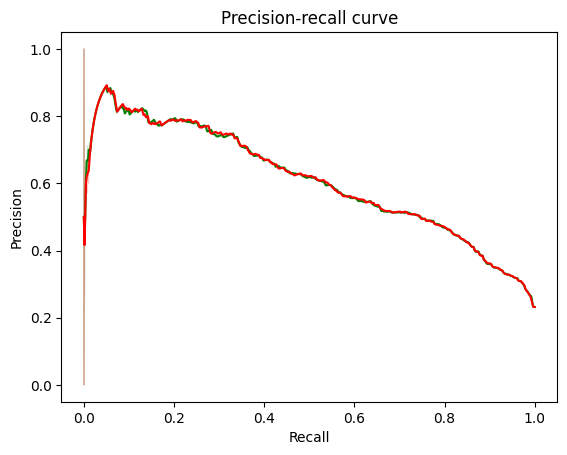

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.lineplot(x = recall_default, y = precision_default, color = 'g')
sns.lineplot(x = recall_best, y = precision_best, color = 'r')
plt.title('Precision-recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## Part 8. Plot ROC Curves and Compute the AUC for Both Models

You will next use scikit-learn's `roc_curve()` function to plot the receiver operating characteristic (ROC) curve and the `auc()` function to compute the area under the curve (AUC) for both models.

* An ROC curve plots the performance of a binary classifier for varying classification thresholds. It plots the fraction of true positives out of the positives vs. the fraction of false positives out of the negatives. For more information on how to use the `roc_curve()` function, consult the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html).

* The AUC measures the trade-off between the true positive rate and false positive rate. It provides a broad view of the performance of a classifier since it evaluates the performance for all the possible threshold values; it essentially provides a value that summarizes the the ROC curve. For more information on how to use the `auc()` function, consult the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html).

Let's first import the functions.

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

<b>Task:</b> Using the `roc_curve()` function, record the true positive and false positive rates for both models. 

1. Call `roc_curve()` with arguments `y_test` and `proba_predictions_default`. The `roc_curve` function produces three outputs. Save the three items to the following variables, respectively: `fpr_default` (standing for 'false positive rate'),  `tpr_default` (standing for 'true positive rate'), and `thresholds_default`.

2. Call `roc_curve()` with arguments `y_test` and `proba_predictions_best`. The `roc_curve` function produces three outputs. Save the three items to the following variables, respectively: `fpr_best` (standing for 'false positive rate'),  `tpr_best` (standing for 'true positive rate'), and `thresholds_best`.

In [18]:
fpr_default, tpr_default, thresholds_default = roc_curve(y_test, proba_predictions_default)
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, proba_predictions_best)

<b>Task</b>: Create <b>two</b> `seaborn` lineplots to visualize the ROC curve for both models. 

The plot for the default hyperparameter should be green. The plot for the best hyperparameter should be red.

* In each plot, the `fpr` values should be on the $x$-axis.
* In each plot, the`tpr` values should be on the $y$-axis. 
* In each plot, label the $x$-axis "False positive rate".
* In each plot, label the $y$-axis "True positive rate".
* Give each plot the title "Receiver operating characteristic (ROC) curve".
* Create a legend on each plot indicating that the plot represents either the default hyperparameter value or the best hyperparameter value.

<b>Note:</b> It may take a few minutes to produce each plot.

#### Plot ROC Curve for Default Hyperparameter:

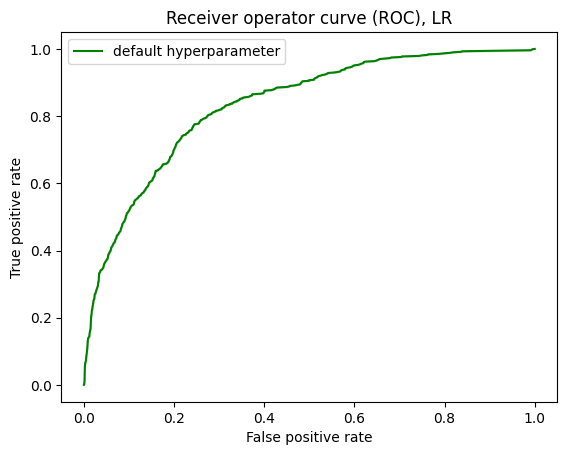

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.lineplot(x = fpr_default, y = tpr_default, color = 'g')
plt.title('Receiver operator curve (ROC), LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(['default hyperparameter'])
plt.show()

#### Plot ROC Curve for Best Hyperparameter:

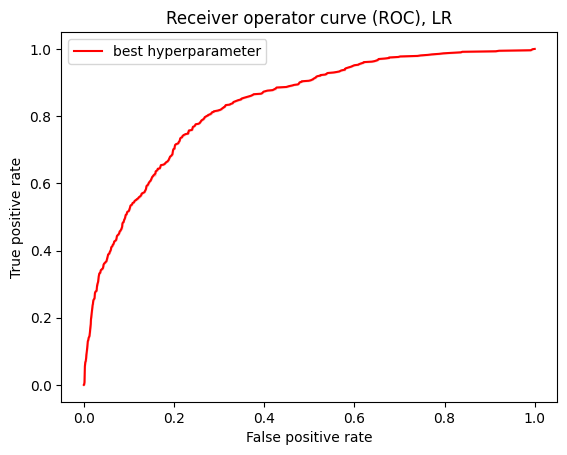

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.lineplot(x = fpr_best, y = tpr_best, color = 'r')
plt.title('Receiver operator curve (ROC), LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(['best hyperparameter'])
plt.show()

<b>Task</b>: Use the `auc()` function to compute the area under the receiver operating characteristic (ROC) curve for both models.

For each model, call the function with the `fpr` argument first and the `tpr` argument second. 

Save the result of the `auc()` function for `model_default` to the variable `auc_default`.
Save the result of the `auc()` function for `model_best` to the variable `auc_best`. 
Compare the results.

In [21]:
auc_default = auc(fpr_default, tpr_default)
auc_best = auc(fpr_best, tpr_best)

print(auc_default)
print(auc_best)

0.8326129907736064
0.832801123934687


## Deep Dive: Feature Selection Using SelectKBest

In the code cell below, you will see how to use scikit-learn's `SelectKBest` class to obtain the best features in a given data set using a specified scoring function. For more information on how to use `SelectKBest`, consult the online [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html).

We will extract the best 5 features from the Airbnb "listings" data set to create new training data, then fit our model with the optimal hyperparameter $C$ to the data and compute the AUC. Walk through the code to see how it works and complete the steps where prompted. Analyze the results.

In [22]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Note that k=5 is specifying that we want the top 5 features
selector = SelectKBest(f_classif, k=5)
selector.fit(X, y)
filter = selector.get_support()
top_5_features = X.columns[filter]

print("Best 5 features:")
print(top_5_features)

# Create new training and test data for features
new_X_train = X_train[top_5_features]
new_X_test = X_test[top_5_features]


# Initialize a LogisticRegression model object with the best value of hyperparameter C 
# The model object should be named 'model'
# Note: Supply max_iter=1000 as an argument when creating the model object
model = LogisticRegression(max_iter = 1000, C = best_C)

# Fit the model to the new training data
model.fit(new_X_train, y_train)


# Use the predict_proba() method to use your model to make predictions on the new test data 
# Save the values of the second column to a list called 'proba_predictions'
proba_predictions = list(model.predict_proba(new_X_test)[:, 1])


# Compute the auc-roc
fpr, tpr, thresholds = roc_curve(y_test, proba_predictions)
auc_result = auc(fpr, tpr)
print(auc_result)


Best 5 features:
Index(['host_response_rate', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_cleanliness'],
      dtype='object')
0.8048833789001864


<b>Task</b>: Consider the results. Change the specified number of features and re-run your code. Does this change the AUC value? What number of features results in the best AUC value? Record your findings in the cell below.

<Double click this Markdown cell to make it editable, and record your findings here.>

## Part 9. Make Your Model Persistent

You will next practice what you learned in the "Making Your Model Persistent" activity, and use the `pickle` module to save `model_best`.

First we will import the pickle module.

In [23]:
import pickle

<b>Task:</b> Use `pickle` to save your model to a `pkl` file in the current working directory. Choose the name of the file.

In [24]:
pkl_model_filename = 'LR_Model.pkl'
pickle.dump(model, open(pkl_model_filename, 'wb'))

<b>Task:</b> Test that your model is packaged and ready for future use by:

1. Loading your model back from the file 
2. Using your model to make predictions on `X_test`.

In [27]:
persistent_model = pickle.load(open(pkl_model_filename, 'rb'))

<b>Task:</b> Download your `pkl` file and your `airbnbData_train` data set, and push these files to your GitHub repository. You can download these files by going to `File -> Open`. A new tab will open in your browser that will allow you to select your files and download them.